In [1]:
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
from scipy.signal import savgol_filter
import seaborn as sns

from memory import MemoryBuffer
from DDPG import DDPGAgent

In [2]:
# Initialize env and set up hyperparameters
env = gym.make('LunarLanderContinuous-v2')
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]

# set seed
seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 


# replay buffer
memory_buffer = MemoryBuffer(max_size=50_000)

start_training_after = 10000 # start training NN after this many timesteps
# number of timesteps that the agent should interact with the environment before starting to train the neural networks.
# This is done to allow the agent to collect enough data to start learning from.

episodes = 1000    
discount = 0.99
batch_size = 32
exploration_noise = 0.1
hidden_size = 64
actor_lr = 0.0005
critic_lr = 0.0005
reward_scale = 0.01

# create DDPG Agent
agent = DDPGAgent(state_size=state_size, 
                  action_size=action_size, 
                  hidden_size=hidden_size, 
                  actor_lr=actor_lr, 
                  critic_lr=critic_lr, 
                  discount=discount, 
                  min_action=min_action,
                  max_action=max_action, 
                  exploration_noise=exploration_noise)

### Training Loop

In [3]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state, _ = env.reset()
    # state = env.reset()

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 195:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()

        # select an action from the agent's policy
        action = agent.act(state)
        
        # enter action into the env
        next_state, reward, done, _, _ = env.step(action)
        # next_state, reward, done, _ = env.step(action)

        total_reward += reward
        episode_length += 1
        # end episode early
        if total_reward < -250:
            done = 1
        
        # add transition to replay buffer
        memory_buffer.add((state, action, reward*reward_scale, next_state, 1-float(done)))
        
        # train the agent
        if timesteps >= start_training_after:
            actor_loss, critic_loss = agent.train(memory_buffer, batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft(timesteps)
            
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if timesteps >= start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    '\tTimestep: {}'.format(timesteps),
                    '\tTotal reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    '\tEpisode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    '\tActor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                    '\tCritic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break
        
        state = next_state

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 8x64)

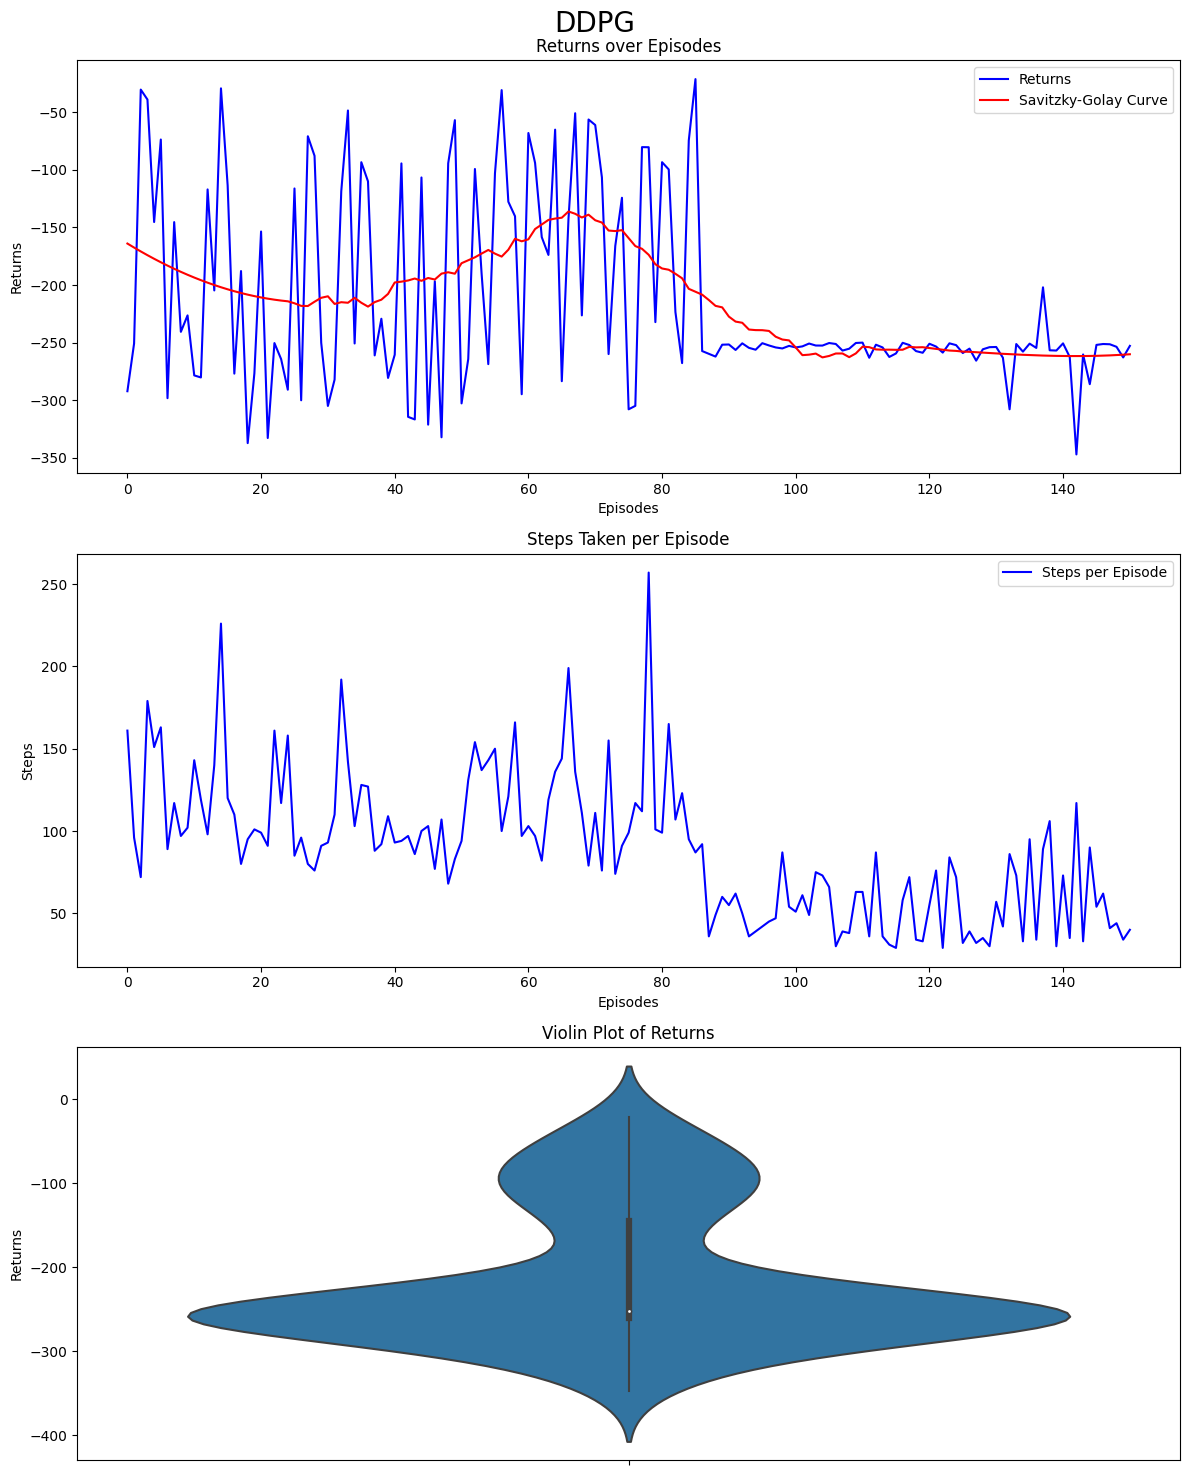

In [ ]:
episode, returns, steps = np.array(stats_rewards_list).T

# Determine the window length based on the size of the data
window_length = min(50, len(returns))

# Apply Savitzky-Golay filter
smoothed_returns = savgol_filter(returns, window_length=window_length, polyorder=3)
# MA = pd.Series(returns).rolling(window=100).mean()

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Plot returns and smoothed returns
sns.lineplot(data=returns, label='Returns', color='blue', ax=axs[0])
sns.lineplot(data=smoothed_returns, label='Savitzky-Golay Curve', color='red', ax=axs[0])
# sns.lineplot(data=MA, label='Smoothed Returns', color='red', ax=axs[0])
axs[0].set_ylabel('Returns')
axs[0].set_xlabel('Episodes')
axs[0].set_title('Returns over Episodes')
axs[0].legend()

# Plot steps taken per episode
sns.lineplot(x=episode, y=steps, label='Steps per Episode', color='blue', ax=axs[1])
axs[1].set_ylabel('Steps')
axs[1].set_xlabel('Episodes')
axs[1].set_title('Steps Taken per Episode')
axs[1].legend()

# Plot violin plot of returns
sns.violinplot(y=returns, ax=axs[2])
axs[2].set_ylabel('Returns')
axs[2].set_title('Violin Plot of Returns')

plt.suptitle('DDPG', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(agent.actor.state_dict(), 'Trained_Agents/DDPG_actor.pth')
torch.save(agent.critic.state_dict(), 'Trained_Agents/DDPG_critic.pth')

torch.save(agent.actor_target.state_dict(), 'Trained_Agents/DDPG_actor_target.pth')
torch.save(agent.critic_target.state_dict(), 'Trained_Agents/DDPG_critic_target.pth')